In [1]:
!pip install --upgrade tensorflow

      Successfully uninstalled tensorflow-2.9.2


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Instanciando la red pre-entrenada MobileNet para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras import regularizers
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

In [26]:
conv_base  = keras.applications.mobilenet.MobileNet(
    weights="imagenet",
    include_top=False)

In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJO/Trabajos_ciencia_de_datos/Clasificacion_imagenes/Dataset_bien.zip

Ajustando los datos de la BD


In [27]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    'Dataset_bien/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
validation_dataset = image_dataset_from_directory(
    'Dataset_bien/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'Dataset_bien/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 1158 files belonging to 4 classes.
Found 252 files belonging to 4 classes.
Found 287 files belonging to 4 classes.


In [28]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [29]:
train_ds = train_dataset.unbatch()
images = np.array(list(train_ds.map(lambda x, y: x)))
labels = np.array(list(train_ds.map(lambda x, y: y)))

val_ds = validation_dataset.unbatch()
images_val = np.array(list(val_ds.map(lambda x, y: x)))
labels_val = np.array(list(val_ds.map(lambda x, y: y)))

### **Entrenamiento**
Primero entrenaré unas épocas con MobileNet congelado, esto permitirá afinar las capas que agregué



In [30]:
conv_base.trainable = False

Transformaciones para expandir las imágenes y definición de la arquitectura


In [31]:
def create_model():
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    )

    inputs = keras.Input(shape=(180, 180, 3))
    x = data_augmentation(inputs)
    #x = keras.applications.mobilenet.preprocess_input(x)
    x = conv_base(x)
    x = layers.Flatten()(x)
    x = layers.Dense(768)(x)#, kernel_regularizer=regularizers.l1_l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(4, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    return model

In [39]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#callbacks = [EarlyStopping(monitor='val_loss', patience=10),
#             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

Fijar los hiperparámetros y entrenar la red

In [33]:
images = np.array([i/255 for i in images])

In [34]:
len(images[0][0][0])

3

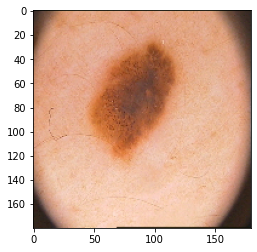

In [35]:
plt.imshow(images[0])

In [36]:
labels_arr = np.array(labels)

In [40]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

history = []
scores = []

length = len(images)

for train, test in kfold.split(images, np.zeros(length)):
  
    model = create_model()

    model.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
                metrics=["accuracy"])

    history.append(model.fit(
                images[train],
                labels_arr[train],
                epochs=1000,  #30
                batch_size=64,
                validation_data=(images[test], labels_arr[test]),
                callbacks=callbacks)
    )

    scores.append(model.evaluate(images[test], labels_arr[test]))

Epoch 1/1000


15/15 [==============================] - 11s 407ms/step - loss: 16.6729 - accuracy: 0.2624 - val_loss: 10.9909 - val_accuracy: 0.2457
Epoch 2/1000
15/15 [==============================] - 5s 361ms/step - loss: 10.2247 - accuracy: 0.2527 - val_loss: 3.0744 - val_accuracy: 0.2888
Epoch 3/1000
15/15 [==============================] - 5s 353ms/step - loss: 9.2614 - accuracy: 0.2451 - val_loss: 8.5289 - val_accuracy: 0.2888
Epoch 4/1000
15/15 [==============================] - 5s 361ms/step - loss: 8.9568 - accuracy: 0.2516 - val_loss: 3.6965 - val_accuracy: 0.2888
Epoch 5/1000
15/15 [==============================] - 5s 358ms/step - loss: 8.8909 - accuracy: 0.2581 - val_loss: 5.5802 - val_accuracy: 0.2026
Epoch 6/1000
15/15 [==============================] - 5s 355ms/step - loss: 6.5360 - accuracy: 0.2419 - val_loss: 7.8771 - val_accuracy: 0.2629
Epoch 7/1000
15/15 [==============================] - 5s 366ms/step - loss: 8.0136 - accuracy: 0.2700 - val_loss: 9.6992 - val_accuracy: 0.2457
E

Epoch 1/1000


15/15 [==============================] - 10s 402ms/step - loss: 17.4889 - accuracy: 0.2570 - val_loss: 11.5308 - val_accuracy: 0.2112
Epoch 2/1000
15/15 [==============================] - 5s 353ms/step - loss: 10.6499 - accuracy: 0.2613 - val_loss: 11.8054 - val_accuracy: 0.2112
Epoch 3/1000
15/15 [==============================] - 5s 355ms/step - loss: 8.2269 - accuracy: 0.2516 - val_loss: 7.9163 - val_accuracy: 0.2974
Epoch 4/1000
15/15 [==============================] - 5s 359ms/step - loss: 9.4177 - accuracy: 0.2559 - val_loss: 9.4850 - val_accuracy: 0.2112
Epoch 5/1000
15/15 [==============================] - 5s 359ms/step - loss: 9.1771 - accuracy: 0.2441 - val_loss: 7.4933 - val_accuracy: 0.2284
Epoch 6/1000
15/15 [==============================] - 5s 359ms/step - loss: 7.5698 - accuracy: 0.2657 - val_loss: 9.4362 - val_accuracy: 0.2629
Epoch 7/1000
15/15 [==============================] - 6s 371ms/step - loss: 7.9860 - accuracy: 0.2462 - val_loss: 4.7125 - val_accuracy: 0.2284


Epoch 1/1000


15/15 [==============================] - 12s 398ms/step - loss: 17.5937 - accuracy: 0.2473 - val_loss: 16.2592 - val_accuracy: 0.2716
Epoch 2/1000
15/15 [==============================] - 5s 363ms/step - loss: 10.9357 - accuracy: 0.2354 - val_loss: 8.8654 - val_accuracy: 0.2759
Epoch 3/1000
15/15 [==============================] - 5s 356ms/step - loss: 8.9752 - accuracy: 0.2635 - val_loss: 7.7157 - val_accuracy: 0.2759
Epoch 4/1000
15/15 [==============================] - 5s 359ms/step - loss: 8.4125 - accuracy: 0.2873 - val_loss: 10.9353 - val_accuracy: 0.2716
Epoch 5/1000
15/15 [==============================] - 5s 357ms/step - loss: 8.7063 - accuracy: 0.2441 - val_loss: 9.0998 - val_accuracy: 0.2414
Epoch 6/1000
15/15 [==============================] - 5s 360ms/step - loss: 7.5804 - accuracy: 0.2538 - val_loss: 8.3645 - val_accuracy: 0.2414
Epoch 7/1000
15/15 [==============================] - 5s 350ms/step - loss: 7.2967 - accuracy: 0.2635 - val_loss: 3.8278 - val_accuracy: 0.2414


Epoch 1/1000


15/15 [==============================] - 11s 440ms/step - loss: 18.1834 - accuracy: 0.2330 - val_loss: 19.5047 - val_accuracy: 0.2814
Epoch 2/1000
15/15 [==============================] - 5s 357ms/step - loss: 11.1140 - accuracy: 0.2211 - val_loss: 9.1370 - val_accuracy: 0.2944
Epoch 3/1000
15/15 [==============================] - 5s 358ms/step - loss: 8.9383 - accuracy: 0.2449 - val_loss: 6.9145 - val_accuracy: 0.2208
Epoch 4/1000
15/15 [==============================] - 5s 361ms/step - loss: 8.5764 - accuracy: 0.2373 - val_loss: 12.3150 - val_accuracy: 0.2208
Epoch 5/1000
15/15 [==============================] - 5s 362ms/step - loss: 8.6439 - accuracy: 0.2729 - val_loss: 8.2687 - val_accuracy: 0.2814
Epoch 6/1000
15/15 [==============================] - 5s 348ms/step - loss: 9.2234 - accuracy: 0.2503 - val_loss: 4.4894 - val_accuracy: 0.2944
Epoch 7/1000
15/15 [==============================] - 5s 354ms/step - loss: 7.6170 - accuracy: 0.2546 - val_loss: 9.3744 - val_accuracy: 0.2208


KeyboardInterrupt: ignored

In [ ]:
scores = np.array(scores)
scores

In [ ]:
np.mean(scores[:,1])

In [ ]:
np.std(scores[:,1])